In [1]:
import os
import datetime
import numpy as np
import cv2
import natsort
import math
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
np.seterr(over='ignore')
if __name__ == '__main__':
    pass

def color_correction(r,u_r,u_ref,L2):
    L1 = np.max(r)
    gainFactor = L1 * (u_r/ u_ref) +L2
    Out = r / gainFactor
    return Out

def OptimalParameter(sceneRadiance):
    img = np.float64(sceneRadiance / 255)
    b, g, r = cv2.split(img)

    u_r = np.sum(r)
    u_g = np.sum(g)
    u_b = np.sum(b)
    u_ref = (u_r ** 2 + u_g ** 2 + u_b ** 2) ** 0.5
    L2 = 0.25
    r = color_correction(r, u_r, u_ref, L2)
    g = color_correction(g, u_g, u_ref, L2)
    b = color_correction(b, u_b, u_ref, L2)

    sceneRadiance = np.zeros((img.shape), 'float64')
    sceneRadiance[:, :, 0] = b
    sceneRadiance[:, :, 1] = g
    sceneRadiance[:, :, 2] = r
    sceneRadiance = sceneRadiance * 255
    sceneRadiance = np.clip(sceneRadiance,0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    return sceneRadiance


In [3]:
def depthMap(img):

    theta_0 = 0.51157954
    theta_1 = 0.50516165
    theta_2 = -0.90511117
    img = img / 255.0
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    x_1 = np.maximum(g, b)
    x_2 = r

    Deptmap = theta_0 + theta_1 * x_1 + theta_2 * x_2


    return Deptmap


In [4]:
def  minDepth(img, BL):
    img = img/255.0
    BL = BL/255.0
    Max = []
    img = np.float32(img)
    for i in range(0,3):
        Max_Abs =  np.absolute(img[i] - BL[i])
        Max_I = np.max(Max_Abs)
        Max_B = np.max([BL[i],(1 -BL[i])])
        temp  = Max_I / Max_B
        Max.append(temp)
    K_b = np.max(Max)
    min_depth = 1 - K_b

    return min_depth


In [5]:
def Depth_TM(img, AtomsphericLight):

    DepthMap = depthMap(img)
    t0, t1 = 0.05, 0.95
    DepthMap = DepthMap.clip(t0, t1)
    d_0 = minDepth(img, AtomsphericLight)

    d_f = 8 * (DepthMap + d_0)
    TM_R_modified = 0.85 ** d_f
    return TM_R_modified

In [6]:
def Sat_max(img):
    height = len(img)
    width = len(img[0])
    # print('img[0,0,:]',img[0,0,:])
    Sat = np.zeros((height,width ))
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if(np.max(img[i,j,:]) == 0):
                Sat[i,j] = 1
            else:
                Sat[i, j] = (np.max(img[i,j,:]) - np.min(img[i,j,:]))/np.max(img[i,j,:])
    Sat = 1 - Sat

    # lamba = 1 - np.mean(Sat)
    lamba = 1

    Sat = Sat * lamba
    return Sat

In [7]:
def getGBTransmissionESt(transmissionR,AtomsphericLightTM):
    depth_map = np.zeros(transmissionR.shape)
    for i in range(0,transmissionR.shape[0]):
        for j in range(0, transmissionR.shape[1]):
            depth_map[i,j]  = math.log(transmissionR[i,j],0.82)

    transmissionG = 0.93 ** depth_map
    transmissionB = 0.95 ** depth_map
    return transmissionB,transmissionG,depth_map

In [8]:
class GuidedFilter:
    
    # def __init__(self, I, radius=5, epsilon=0.4):
    def __init__(self, I, radius, epsilon):

        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = self._toFloatImg(I)
        self._initFilter()


    def _toFloatImg(self, img):
        if img.dtype == np.float32:
            return img
        return ( 1.0 / 255.0 ) * np.float32(img)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]


        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps                                       
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean                                  
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean                                  
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps                            
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean                                  
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps                                                       


        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var                                                      
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var                                                      
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var                                                      
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var                                                      
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var                                                      
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var                                                      
        
        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var                                    
        Irr_inv /= I_cov                                                                                     
        Irg_inv /= I_cov                                                                                     
        Irb_inv /= I_cov                                                                                     
        Igg_inv /= I_cov                                                                                     
        Igb_inv /= I_cov                                                                                     
        Ibb_inv /= I_cov                                                                                     
        
        self._Irr_inv = Irr_inv                                                                              
        self._Irg_inv = Irg_inv                                                                              
        self._Irb_inv = Irb_inv                                                                              
        self._Igg_inv = Igg_inv                                                                              
        self._Igb_inv = Igb_inv                                                                              
        self._Ibb_inv = Ibb_inv                  

    def _computeCoefficients(self, p):
        r = self._radius                                                             
        I = self._I                                                                 
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]                                                          
        

        p_mean = cv2.blur(p, (r, r))                             
        Ipr_mean = cv2.blur(Ir * p, (r, r))                                                         
        Ipg_mean = cv2.blur(Ig * p, (r, r))                                                    
        Ipb_mean = cv2.blur(Ib * p, (r, r))             



        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean                                                 
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean                                                     
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean                                                       
                                                                                                                 
        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov                 
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov                
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov    

        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean                                                                                                                                         

        ar_mean = cv2.blur(ar, (r, r))          
        ag_mean = cv2.blur(ag, (r, r))                                                                   
        ab_mean = cv2.blur(ab, (r, r))                                                                      
        b_mean = cv2.blur(b, (r, r))                                                                                                                                              

        return ar_mean, ag_mean, ab_mean, b_mean            

    def _computeOutput(self, ab, I):
    
        ar_mean, ag_mean, ab_mean, b_mean = ab
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]
        q = ar_mean * Ir + ag_mean * Ig + ab_mean * Ib + b_mean
        return q

    def filter(self, p):

        p_32F = self._toFloatImg(p)

        ab = self._computeCoefficients(p)
        return self._computeOutput(ab, self._I)

In [9]:

def  Refinedtransmission(transmissionB,transmissionG,transmissionR_Stretched,img):


    gimfiltR = 50  
    eps = 10 ** -3  

    guided_filter = GuidedFilter(img, gimfiltR, eps)
    transmissionR_Stretched = guided_filter.filter(transmissionR_Stretched)
    transmissionG = guided_filter.filter(transmissionG)
    transmissionB = guided_filter.filter(transmissionB)

    transmission = np.zeros(img.shape)
    transmission[:, :, 0] = transmissionB
    transmission[:, :, 1] = transmissionG
    transmission[:, :, 2] = transmissionR_Stretched
    transmission = np.clip(transmission,0.05, 0.95)

    return transmission

In [10]:
def getMinChannel(img,AtomsphericLight):
    imgGrayNormalization = np.zeros((img.shape[0], img.shape[1]), dtype=np.float16)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            localMin = 1
            for k in range(0, 3):
                # print('AtomsphericLight[k]',AtomsphericLight[k])
                imgNormalization = img.item((i, j, k)) / AtomsphericLight[k]
                if imgNormalization < localMin:
                    localMin = imgNormalization
            imgGrayNormalization[i, j] = localMin
    # print('imgGrayNormalization',imgGrayNormalization)
    # print('np.max(imgGrayNormalization)',np.max(imgGrayNormalization))
    return imgGrayNormalization

def getTransmission(img,AtomsphericLight ,blockSize):
    img = np.float16(img)
    img = getMinChannel(img,AtomsphericLight)
    AtomsphericLight = AtomsphericLight / 255.0
    addSize = int((blockSize - 1) / 2)
    newHeight = img.shape[0] + blockSize - 1
    newWidth = img.shape[1] + blockSize - 1
    imgMiddle = np.zeros((newHeight, newWidth))
    imgMiddle[:, :] = 1
    imgMiddle[addSize:newHeight - addSize, addSize:newWidth - addSize] = img
    # print('imgMiddle',imgMiddle)
    imgDark = np.zeros((img.shape[0], img.shape[1]))
    localMin = 1
    for i in range(addSize, newHeight - addSize):
        for j in range(addSize, newWidth - addSize):
            localMin = 1
            for k in range(i - addSize, i + addSize + 1):
                for l in range(j - addSize, j + addSize + 1):
                    if imgMiddle.item((k, l)) < localMin:
                        localMin = imgMiddle.item((k, l))
            imgDark[i - addSize, j - addSize] = localMin
        transmission = (1 - imgDark) / (1 - 0.1 / np.max(AtomsphericLight))
    transmission = np.clip(transmission, 0.1, 0.9)

    return transmission

In [11]:
pi = math.pi
e = math.e

def global_stretching_depth(img_L):
    height = len(img_L)
    width = len(img_L[0])
    length = height * width
    R_rray = []
    for i in range(height):
        for j in range(width):
            R_rray.append(img_L[i][j])
    R_rray.sort()
    I_min = R_rray[int(length / 1000)]
    I_max = R_rray[-int(length / 1000)]
    print('I_min',I_min)
    print('I_max',I_max)
    array_Global_histogram_stretching_L = np.zeros((height, width))
    for i in range(0, height):
        for j in range(0, width):
            if img_L[i][j] < I_min:
                p_out = img_L[i][j]
                array_Global_histogram_stretching_L[i][j] = 0.2
            elif (img_L[i][j] > I_max):
                p_out = img_L[i][j]
                array_Global_histogram_stretching_L[i][j] = 0.9
            else:
                p_out = (img_L[i][j] - I_min) * ((0.9-0.2) / (I_max - I_min))+ 0.2
                array_Global_histogram_stretching_L[i][j] = p_out
    return (array_Global_histogram_stretching_L)



def stretching(sceneRadiance,height, width):

    r_array_Global_histogram_stretching = global_stretching_depth(sceneRadiance)
    sceneRadiance = r_array_Global_histogram_stretching


    return sceneRadiance

In [12]:

def sceneRadianceRGB(img, transmission, AtomsphericLight):
    sceneRadiance = np.zeros(img.shape)
    img = np.float32(img)
    for i in range(0, 3):
        sceneRadiance[:, :, i] = (img[:, :, i] - AtomsphericLight[i]) / transmission[:, :, i]  + AtomsphericLight[i]


    sceneRadiance = np.clip(sceneRadiance, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    return sceneRadiance

In [13]:
np.seterr(over='ignore')
if __name__ == '__main__':
    pass

In [14]:
#starttime = datetime.datetime.now()

In [15]:
#path = "InputImages"
#files = os.listdir(path)
#files =  natsort.natsorted(files)

C:/Users/hp/Downloads/project/underwater images/626_img_.png
I_min 0.5319148898124695
I_max 0.8354430347681046


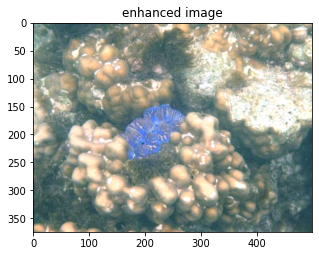

In [18]:
import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter import filedialog
#Create an instance of tkinter frame or window
win= Tk()
win.geometry("750x150")
win.configure(bg='SkyBlue2')
from PIL import ImageTk, Image
#Define a function to Opening the specific file using filedialog

def pred():
    print(path)
    img = cv2.imread(path)
    my_img = ImageTk.PhotoImage(Image.open('input.png'))
    my_lbl = Label(image=my_img).place(x=5,y=150)
    blockSize = 9
    out_img = []
    height = len(img)
    width = len(img[0])
    gimfiltR = 50  # Radius size of guided filter
    eps = 10 ** -3  # Epsilon value of guided filter
    Nrer = [0.95, 0.93, 0.85] # Normalized residual energy ratio of G-B-R channels

    AtomsphericLight = np.zeros(3)
    AtomsphericLight[0] = (1.13 * np.mean(img[:, :, 0])) + 1.11 * np.std(img[:, :, 0]) - 25.6
    AtomsphericLight[1] = (1.13 * np.mean(img[:, :, 1])) + 1.11 * np.std(img[:, :, 1]) - 25.6
    AtomsphericLight[2] = 140 / (1 + 14.4 * np.exp(-0.034 * np.median(img[:, :, 2])))
    AtomsphericLight = np.clip(AtomsphericLight, 5, 250)
    transmissionR = getTransmission(img, AtomsphericLight, blockSize)
    TM_R_modified = Depth_TM(img, AtomsphericLight)
    TM_R_modified_Art = Sat_max(img)
    transmissionR_new = np.copy(transmissionR)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if(transmissionR_new[i, j] > TM_R_modified[i, j]):
                transmissionR_new[i, j] = TM_R_modified[i, j]
            if(transmissionR_new[i, j] < TM_R_modified_Art[i, j]):
                transmissionR_new[i, j] = TM_R_modified_Art[i, j]

    transmissionR_Stretched = stretching(transmissionR_new, height, width)
    transmissionB, transmissionG, depth_map = getGBTransmissionESt(transmissionR_Stretched, AtomsphericLight)
    transmission = Refinedtransmission(transmissionB, transmissionG, transmissionR_Stretched, img)
    sceneRadiance = sceneRadianceRGB(img, transmission, AtomsphericLight)
    #cv2.imwrite('OutputImages/' + prefix + '_1.jpg', sceneRadiance)
    sceneRadiance = OptimalParameter(sceneRadiance)
    #cv2.imwrite('en_img.png', sceneRadiance)
    out_img.append(sceneRadiance)
    plt.imshow(cv2.cvtColor(out_img[0], cv2.COLOR_BGR2RGB))
    plt.title("enhanced image")
    plt.savefig('imgnew.png')
    my_img1 = ImageTk.PhotoImage(Image.open('imgnew.png'))
    my_lbl1 = Label(image=my_img1).place(x=450,y=150)
        

    
def open_files():
    global path
    path= filedialog.askopenfilename(title="Select a file", filetypes=(("image files","*.png"),("all files","*.*")))
    #file= open(path,'r')
    #label.config(text=txt, font=('Courier 13 bold'))
    #file.close()
    #button.config(state=DISABLED)
    win.geometry("900x750")
    #plt.figure(figsize=(10, 10))
    input_img =[]
    
    image = load_img(path)
    input_img.append(image)
    plt.figure(figsize=(5, 5))
    plt.title("input image")
    plt.imshow(input_img[0])
    plt.savefig('input.png')
    my_img = ImageTk.PhotoImage(Image.open('input.png'))
    my_lbl2 = Label(image=my_img).place(x=5,y=150)
    button1=ttk.Button(win, text="Restore",command=pred)
    button1.place(x=450,y=80)

#logo
# logo=Image.open('logo.png')
# logo=logo.resize((350, 350))
# logo = ImageTk.PhotoImage(logo)
# logo_label = tk.Label(image= logo)
# logo_label.image = logo
# logo_label.pack()

#Create an Empty Label to Read the content of the File
label= Label(win,text="Underwater Image Restoration", font=('Times','24'))
label.pack()
#Create a button for opening files
button=ttk.Button(win, text="Open",command=open_files)
button.place(x=350,y=80)

win.mainloop()

In [1]:
import tkinter
tkinter.TkVersion


8.6

In [2]:
import PIL
PIL.__version__

'8.4.0'